<a href="https://colab.research.google.com/github/tphlru/rzd_detector/blob/main/audio_speech_emotion_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa kaggle

Будем использовать датасеты SAVEE, RAVDESS, CREMA-D, TESS, RESD

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "tim0820"
os.environ['KAGGLE_KEY'] = "e8f8510dac43db1d8218445c8cc13483"

import kaggle

kaggle.api.authenticate()

datasets_paths = {
    "savee": "./SAVEE_dataset/",
    "ravdess": "./RAVDESS_dataset/",
    "cremad": "./CREMA_dataset/",
    "tess": "./TESS_dataset/",
    "resd": "./RESD_dataset/",
}

kaggle.api.dataset_download_files('uwrfkaggler/ravdess-emotional-speech-audio', path=datasets_paths['ravdess'], unzip=True)
kaggle.api.dataset_download_files('ejlok1/surrey-audiovisual-expressed-emotion-savee', path=datasets_paths['savee'], unzip=True)
kaggle.api.dataset_download_files('ejlok1/cremad', path=datasets_paths['cremad'], unzip=True)
kaggle.api.dataset_download_files('ejlok1/toronto-emotional-speech-set-tess', path=datasets_paths['tess'], unzip=True)
kaggle.api.dataset_download_files('ar4ikov/resd-dataset', path=datasets_paths['resd'], unzip=True)



Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
Dataset URL: https://www.kaggle.com/datasets/ar4ikov/resd-dataset


In [28]:
import pandas as pd
import numpy as np
import librosa
import re
import shutil
from IPython.display import Audio, display

# **1. Ravdess - структура данных**
* Формат (01 = full-AV, 02 = video-only, 03 = audio-only).
* Вокальный канал (01 = speech, 02 = song).
* Эмоция (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Интенсивность эмоции (01 = normal, 02 = strong)
* Выражение (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Повтор? (01 = 1st repetition, 02 = 2nd repetition).
* Говорящий (01 to 24. Дикторы с нечётным номером мужчины, а с чётным - женщины).

Вот пример имени фийла. 02-01-06-01-02-01-12.mp4
Это обозначает, что:

* Только видео (02)
* Речь (не пение) (01)
* Эмоция - страх (06)
* Нормальная интенсивность (01)
* Выражение про собак (02)
* Первый повтор (01)
* 12 диктор (12) - Женщина (as the actor ID number is even)

In [4]:
ravdess_df = pd.DataFrame()
emotions, paths = [], []

ravdess_dir_list = os.listdir(datasets_paths['ravdess'])
ravdess_dir_list = [dirname for dirname in ravdess_dir_list if re.match(r'^Actor_\d{2}$', dirname)]

for dirname in ravdess_dir_list:
    actor = os.listdir(datasets_paths['ravdess'] + dirname + '/')
    for filename in actor:
        part = filename.split('.')[0]
        part = part.split('-')

        # Allow speech only, skip song (second part in each filename represents the vocal channel)
        if int(part[1]) == 1:
            # third part in each filename represents the emotion
            emotions.append(int(part[2]))
            paths.append(str(datasets_paths['ravdess'] + dirname + '/' + filename))

ravdess_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

,Emotions,Path
0,neutral,./RAVDESS_dataset/Actor_08/03-01-01-01-02-02-0...
1,calm,./RAVDESS_dataset/Actor_08/03-01-02-01-02-02-0...
2,happy,./RAVDESS_dataset/Actor_08/03-01-03-01-01-01-0...
3,sad,./RAVDESS_dataset/Actor_08/03-01-04-01-02-02-0...
4,calm,./RAVDESS_dataset/Actor_08/03-01-02-01-01-02-0...


# **SAVEE - структура данных**
* KL=angry
* JK=happy
* JE=sad
* DC=neutral

Самый сомнительный из всех. В нём даже человеку не совсем ясно какая эмоция. Что обозначают цыфры и буквы после обозначений - непонятно.

In [5]:
savee_df = pd.DataFrame()
emotions, paths = [], []

savee_dir_list = os.listdir(datasets_paths['savee'] + "/ALL/")

for filename in savee_dir_list:
    emotions.append(filename[:2])
    paths.append(str(datasets_paths['savee'] + "ALL/" + filename))

savee_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )
savee_df.Emotions.replace({"DC":'neutral', "JK":'happy', "JE":'sad', "KL":'angry'}, inplace=True)
savee_df.head()

,Emotions,Path
0,angry,./SAVEE_dataset/ALL/KL_sa09.wav
1,neutral,./SAVEE_dataset/ALL/DC_sa01.wav
2,neutral,./SAVEE_dataset/ALL/DC_d08.wav
3,neutral,./SAVEE_dataset/ALL/DC_su10.wav
4,sad,./SAVEE_dataset/ALL/JE_su14.wav


# **CREMA(-D) - структура данных**

Название файла формата 1001_HAP_SAD_XX.wav, где HAP - условное обозначение эмоции

* 'ANG' = 'angry'
* 'DIS' = 'disgust'
* 'FEA' = 'fear'
* 'HAP' = 'happiness'
* 'NEU' = 'neutral'
* 'SAD' = 'sad'
* 'SUP' = 'surprise'

In [6]:
cremad_df = pd.DataFrame()
emotions, paths = [], []

cremad_dir_list = os.listdir(datasets_paths['cremad'] + 'AudioWAV/')

for filename in cremad_dir_list:
    part = filename.split('.')[0]
    part = part.split('_')

    # third part in each filename represents the emotion
    emotions.append(part[2])
    paths.append(str(datasets_paths['cremad'] + 'AudioWAV/' + filename))

cremad_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )

cremad_df.Emotions.replace({"NEU":'neutral', "HAP":'happy', "SAD":'sad', "ANG":'angry', "FEA":'fear', "DIS":'disgust', "SUP":'surprise'}, inplace=True)
cremad_df.head()

,Emotions,Path
0,fear,./CREMA_dataset/AudioWAV/1064_DFA_FEA_XX.wav
1,angry,./CREMA_dataset/AudioWAV/1054_IEO_ANG_HI.wav
2,happy,./CREMA_dataset/AudioWAV/1091_TAI_HAP_XX.wav
3,disgust,./CREMA_dataset/AudioWAV/1003_IWW_DIS_XX.wav
4,fear,./CREMA_dataset/AudioWAV/1011_ITS_FEA_XX.wav


# **TESS - структура данных**

Содержит папки формата XXX_emotion, в каждой папке своя эмоция своего диктора (но диктор нам не важен)

* 'Fear' = 'fear'
* 'Pleasant_surprise' = 'surprise'
* 'Pleasant_surprised' = 'surprise'
* 'Sad' = 'sad'
* 'angry' = 'angry'
* 'neutral' = 'neutral'
* 'disgust' = 'disgust'
* 'happy' = 'happy'

Эта версия датасета плохо отформатирована

In [7]:
tess_df = pd.DataFrame()
emotions, paths = [], []

tess_dir_list = os.listdir(datasets_paths['tess'] + "TESS Toronto emotional speech set data/")
for dirname in tess_dir_list:
    emo = os.listdir(datasets_paths['tess'] + "TESS Toronto emotional speech set data/" + dirname)
    for filename in emo:
        part = ''.join(dirname.split('_')[1:])
        part = part.lower().replace('_', '').replace('pleasant', '').replace('surprised', 'surprise')
        emotions.append(part)
        paths.append(datasets_paths['tess'] + "TESS Toronto emotional speech set data/" + filename)

ravdess_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

,Emotions,Path
0,fear,./TESS_dataset/TESS Toronto emotional speech s...
1,fear,./TESS_dataset/TESS Toronto emotional speech s...
2,fear,./TESS_dataset/TESS Toronto emotional speech s...
3,fear,./TESS_dataset/TESS Toronto emotional speech s...
4,fear,./TESS_dataset/TESS Toronto emotional speech s...


# **RESD - Структура данных**

Это единственный датасет на русском языке.
Но, он мне не нравится - очень плохо прослеживается эмоция именно в голосе диктора, тут она скорее в значении фразы. Хотя и в голосе неееемного, но есть. Поэтому пока попробуем использовать.

И здесь какое-то странное распределение: счастливая злость - это как????
Распределение здесь по папкам, как в предыдущем. Возьмём и из папки train, и из test. Сами потом поделим на выборки.

* 'happiness' = 'happy'
* 'anger' = 'angry'
* 'disgust' = 'disgust'
* 'fear' = 'fear'
* 'sadness' = 'sad'
* 'enthusiasm' = 'neutral'

А форматирование здесь ещё хуже ....

In [8]:
# shutil.rmtree("/content/RESD_dataset/")
# kaggle.api.dataset_download_files('ar4ikov/resd-dataset', path=datasets_paths['resd'], unzip=True)

In [9]:
# для удобства переместим из папок test и train в одну общую
for source_dir in ['/content/RESD_dataset/test', '/content/RESD_dataset/train']:
    if os.path.exists(source_dir):
        for files in os.listdir(source_dir):
            dest = datasets_paths['resd']
            if os.path.exists(os.path.join(datasets_paths['resd'], files)):
                dest = str(os.path.join(datasets_paths['resd'], "2" + files))
            shutil.move(os.path.join(source_dir, files), dest)
        shutil.rmtree(source_dir)

In [17]:
resd_df = pd.DataFrame()
emotions, paths = [], []

resd_dir_list = os.listdir(datasets_paths['resd'])
for dirname in resd_dir_list:
    if not os.path.isdir(datasets_paths['resd'] + dirname):
        continue
    emo = os.listdir(datasets_paths['resd'] + dirname)
    for filename in emo:
        part = filename.lower()
        if "happiness" in part:
            part = "happy"
        elif "anger" in part:
            part = "angry"
        elif "disgust" in part:
            part = "disgust"
        elif "fear" in part:
            part = "fear"
        elif "sadness" in part:
            part = "sad"
        elif "enthusiasm" in part:
            part = "neutral"
        elif ".csv" in part or "test" in part or "train" in part:
            continue
        emotions.append(part)
        paths.append(datasets_paths['resd'] + filename)

ravdess_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )
ravdess_df

,Emotions,Path
0,disgust,./RESD_dataset/20_disgust_enthusiasm_d_140.wav
1,disgust,./RESD_dataset/20_disgust_enthusiasm_e_160.wav
2,disgust,./RESD_dataset/20_disgust_enthusiasm_e_050.wav
3,disgust,./RESD_dataset/20_disgust_enthusiasm_d_030.wav
4,disgust,./RESD_dataset/20_disgust_enthusiasm_d_040.wav
...,...,...
1391,fear,./RESD_dataset/04_fear_enthusiasm e_040.wav
1392,fear,./RESD_dataset/04_fear_enthusiasm f_110.wav
1393,fear,./RESD_dataset/04_fear_enthusiasm f_150.wav
1394,fear,./RESD_dataset/04_fear_enthusiasm e_150.wav


Теперь объеденим все списки в один большой

In [18]:
all_datasets_df = pd.DataFrame(columns=['Emotions', 'Path'])
all_datasets_df = pd.concat([ravdess_df, savee_df, cremad_df, tess_df, resd_df], ignore_index=True)
print(all_datasets_df['Emotions'].unique())
all_datasets_df

['disgust' 'fear' 'angry' 'sad' 'happy' 'neutral']


,Emotions,Path
0,disgust,./RESD_dataset/20_disgust_enthusiasm_d_140.wav
1,disgust,./RESD_dataset/20_disgust_enthusiasm_e_160.wav
2,disgust,./RESD_dataset/20_disgust_enthusiasm_e_050.wav
3,disgust,./RESD_dataset/20_disgust_enthusiasm_d_030.wav
4,disgust,./RESD_dataset/20_disgust_enthusiasm_d_040.wav
...,...,...
9313,neutral,./CREMA_dataset/AudioWAV/1076_IWW_NEU_XX.wav
9314,disgust,./CREMA_dataset/AudioWAV/1040_IOM_DIS_XX.wav
9315,sad,./CREMA_dataset/AudioWAV/1052_IEO_SAD_MD.wav
9316,angry,./CREMA_dataset/AudioWAV/1020_MTI_ANG_XX.wav


Emotions
happy      1824
angry      1727
disgust    1510
sad        1500
fear       1472
neutral    1285
Name: count, dtype: int64


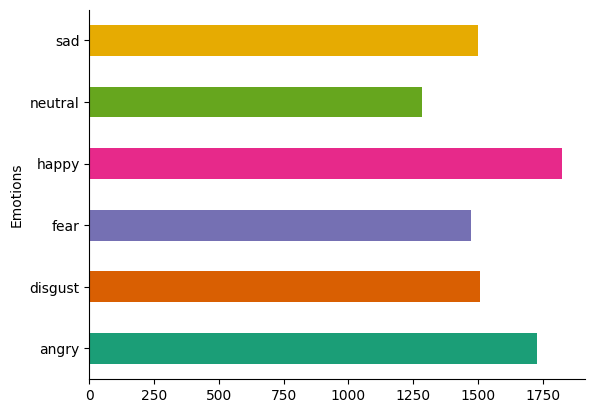

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
all_datasets_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
print(all_datasets_df.Emotions.value_counts())

# **Дополнение данных**
Дополнение данных - это процесс, в ходе которого мы создаем новые синтетические образцы данных, добавляя небольшие изменения в наш исходный обучающий набор. Чем больше данных - тем выше будет точность.

Чтобы создать синтетические данные для аудио, мы можем применить введение шума, смещение времени, изменение высоты тона и скорости.
Цель состоит в том, чтобы сделать нашу модель невосприимчивой к этим возмущениям и повысить ее способность к анализу.

Чтобы это сработало, добавление возмущений должно сохранять ту же метку, что и исходная обучающая выборка.

In [50]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# возьмём любой образец аудио и посмотрим как эти техники влияют на него
testpath = all_datasets_df['Path'].sample(1).values[-1]
print(testpath)
data, sample_rate = librosa.load(testpath)

./CREMA_dataset/AudioWAV/1016_TIE_DIS_XX.wav


1. Оригинал

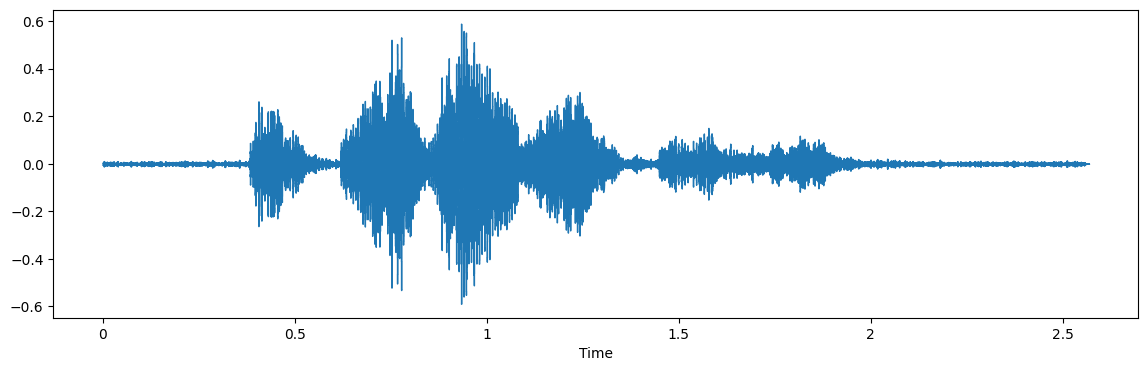

In [42]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(testpath)

2. Внедрение шумов

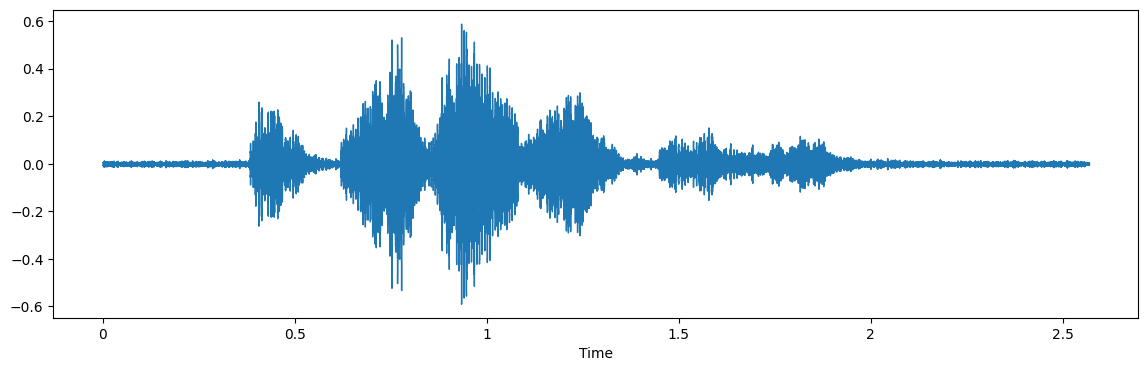

In [41]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# **3. Растяжка**

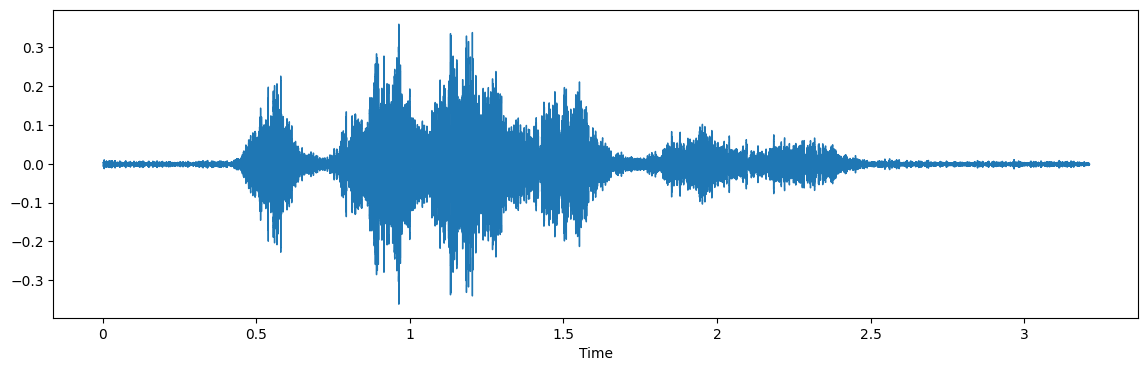

In [40]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## **3. Pitch (высота тона)**

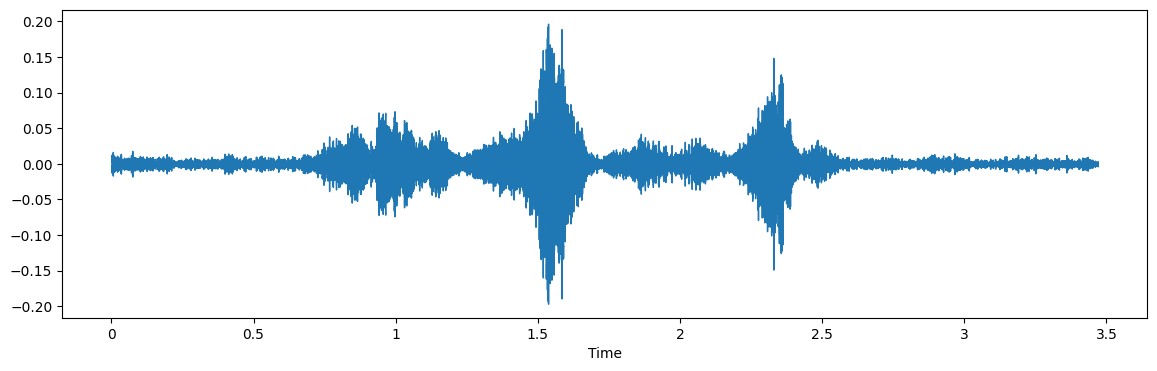

In [51]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)